In [1]:
from IPython.display import display, HTML, Markdown

display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit 

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Simulação eventos\\'

### Constantes 

In [4]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 4200       # número de passos temporais. 2000
skip   = 1          # Taxa de pulos no dados salvos.

t = np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

In [5]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.

muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma= 5/3

## Parâmetros físicos pré-choques obtidos no evento do dia 01/12/2015

In [6]:
v1 = [-500.7491, 52.872524, -17.03108]                # km/s
B1 = [-3.197709, -5.1067386, -1.5899134]              # nT
n1 = 7.9405265                                        # cm^-3
T1 = 75.6668                                          # eV
# vetor normal ao plano de choque
n = [0.8855696, -0.0281544, -0.4636528]

## Transformações referentes aos valores normais e tangenciais 

### Módulo da velocidade na região pré-choque

In [7]:
round(np.linalg.norm(v1),3)          # km/s

503.821

In [8]:
v1n = np.abs(np.dot(v1,n)*1e3)                         # Velocidade pré-choque normal ao plano de choque        [m/s]
B1n = np.dot(B1,n)                                     # Campo magnético pré-choque normal ao plano de choque   

B1t = np.sqrt(np.linalg.norm(B1)**2 - B1n**2)*1e-9     # Campo magnético pré-choque tangente ao plano de choque [T]

B1u = np.array([0,0,B1t])                              # vetor B1t na direção z

### Velocidade pré-choque na direção do vetor normal n

In [9]:
round(v1n,3)         # m/s 

437040.266

### Campo magnético na direção perpendicular ao vetor normal n

In [10]:
round(B1t/1e-9,3)

5.918

In [11]:
B1u           # vetor

array([0.00000000e+00, 0.00000000e+00, 5.91828819e-09])

### Parâmetros derivados

In [12]:
# derived parameters

Eu = -np.cross(np.array([0,v1n,0]),np.array([0,0,B1t]))    # electric field. The same on both sides.
p1 = 2*n1*1e6*1.3806e-23*(T1*1.1604e4)                     # thermal pressure in Pa 
                                                        #(the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)*1e6                                       # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1t)   # thermal gyroradius in m.

In [13]:
round(R1,3)

212386.882

In [14]:
Eu

array([-0.00258653, -0.        , -0.        ])

In [15]:
em = 0.5*(rho1*(v1n**2)+B1t**2/(muo))+p1
    
zeta = ((2*gamma*em-rho1*(v1n**2))
+ np.sqrt((2*gamma*em-rho1*(v1n**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1n*B1t)**2/muo))/(2*rho1*(gamma+1)*v1n**2)

round(zeta,3)

0.356

In [16]:
round(1/zeta,3)

2.812

In [17]:
gamma

1.6666666666666667

## Tabela com os parâmetros de entrada

In [18]:
zz_1 = round(1/zeta,3)
Tb_1 = [dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma, round(zeta,3), zz_1 ]

Tb_1

[0.01, 437.04, 5.918, -2.587, 1.6666666666666667, 0.356, 2.812]

In [19]:
df_1 = pd.DataFrame(Tb_1, index = ['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $'], columns = ['3D'])
df_1.T

,$\Delta t$,"$V_{1,n}$","$B_{1,t}$",$E_1$,$\gamma$,$r$,$\zeta $
3D,0.01,437.04,5.918,-2.587,1.666667,0.356,2.812


## Conversão da tabela para latex

In [20]:
df_1.T[['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $']].rename(
    columns = {'$\Delta t$':'$\Delta t \ [s]$',
               '$V_{1,n}$':'$V_{1,n} \left[ \dfrac{km}{s} \right]$',
               '$B_{1,t}$':'$B_{1,t} \ [nT]$',
               '$E_1$':'$E_1 = E_2 \ [mV]$',
               '$\gamma$':'$\gamma \left [\dfrac{C_P}{C_V} \right]$'  ,
               '$r$':'$r$', 
               '$\zeta $':r"$\zeta = 1/r$"}).to_latex('Parametros_de_entrada_01122015_3D.tex', 
                caption = 'Parâmetros de entrada da simulação para o evento do dia 01/12/2015',
                column_format ='c|ccccccc', escape = False)

## Carregamento dos dados 

In [21]:
vxi = np.loadtxt(path_in+'Vx_MB.txt') 
v_d = np.loadtxt(path_in+'Vy_MB.txt') 
vzi = np.loadtxt(path_in+'Vz_MB.txt'); #n = np.loadtxt(path_in+'n.txt')

## Simulação de boris stepper 3 D 

In [ ]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

z0lower = -1.0
z0upper = 1.0

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)
z = z0lower+rd.random(len(vzi))*(z0upper-z0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ry = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
vy = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]) 
mu = np.zeros([int(Nsteps/skip)+1,len(v_d)])
rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = z[i]*R1
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    vz0 = vzi[i]
    
    v   = np.array([vx0,vy0,vz0])

    v1std = np.linalg.norm(v)
    
    em = 0.5*(rho1*(v1std**2)+B1t**2/(muo))+p1
    
    zeta = ( (2*gamma*em-rho1*(v1std**2))
    + np.sqrt((2*gamma*em-rho1*(v1std**2))**2-4*rho1*(gamma+1)*(gamma-2)*(v1std*B1t)**2/muo))/(2*rho1*(gamma+1)*v1std**2)  
    #zeta = (rho1*(v1std**2)+4*(p1+B1**2/(2*muo)))/(3*rho1*(v1std**2)) 
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1t))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1t)))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        # down boundary condition
        if r[2] < z0lower*R1: r[2] = r[2] + (np.abs(z0upper)+np.abs(z0lower))*R1
        # up boundary condition
        if r[2] > z0upper*R1: r[2] = r[2] - (np.abs(z0upper)+np.abs(z0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento  (primeira iteração)

In [ ]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'3D\\'+'rx.txt', rx)
np.savetxt(path_in+'3D\\'+'ry.txt', ry) 
np.savetxt(path_in+'3D\\'+'rz.txt', rz)  
np.savetxt(path_in+'3D\\'+'vx.txt', vx) 
np.savetxt(path_in+'3D\\'+'vy.txt', vy)  
np.savetxt(path_in+'3D\\'+'vz.txt', vz)   
np.savetxt(path_in+'3D\\'+'ek.txt', ek) 
np.savetxt(path_in+'3D\\'+'mu.txt', mu)  
np.savetxt(path_in+'3D\\'+'rL.txt', rL)

### Carregamentoo

In [63]:
rx = np.loadtxt(path_in+'3D\\'+'rx.txt'); 
ry = np.loadtxt(path_in+'3D\\'+'ry.txt') 
#; rz = np.loadtxt(path_in+'3D\\'+'rz.txt') 
#vx = np.loadtxt(path_in+'3D\\'+'vx.txt'); 
#vy = np.loadtxt(path_in+'3D\\'+'vy.txt') ; 
#vz = np.loadtxt(path_in+'3D\\'+'vz.txt') 

In [64]:
y_p = 2.8748374140817576   # Obtido no script Plot da cicloide 

<IPython.core.display.Javascript object>


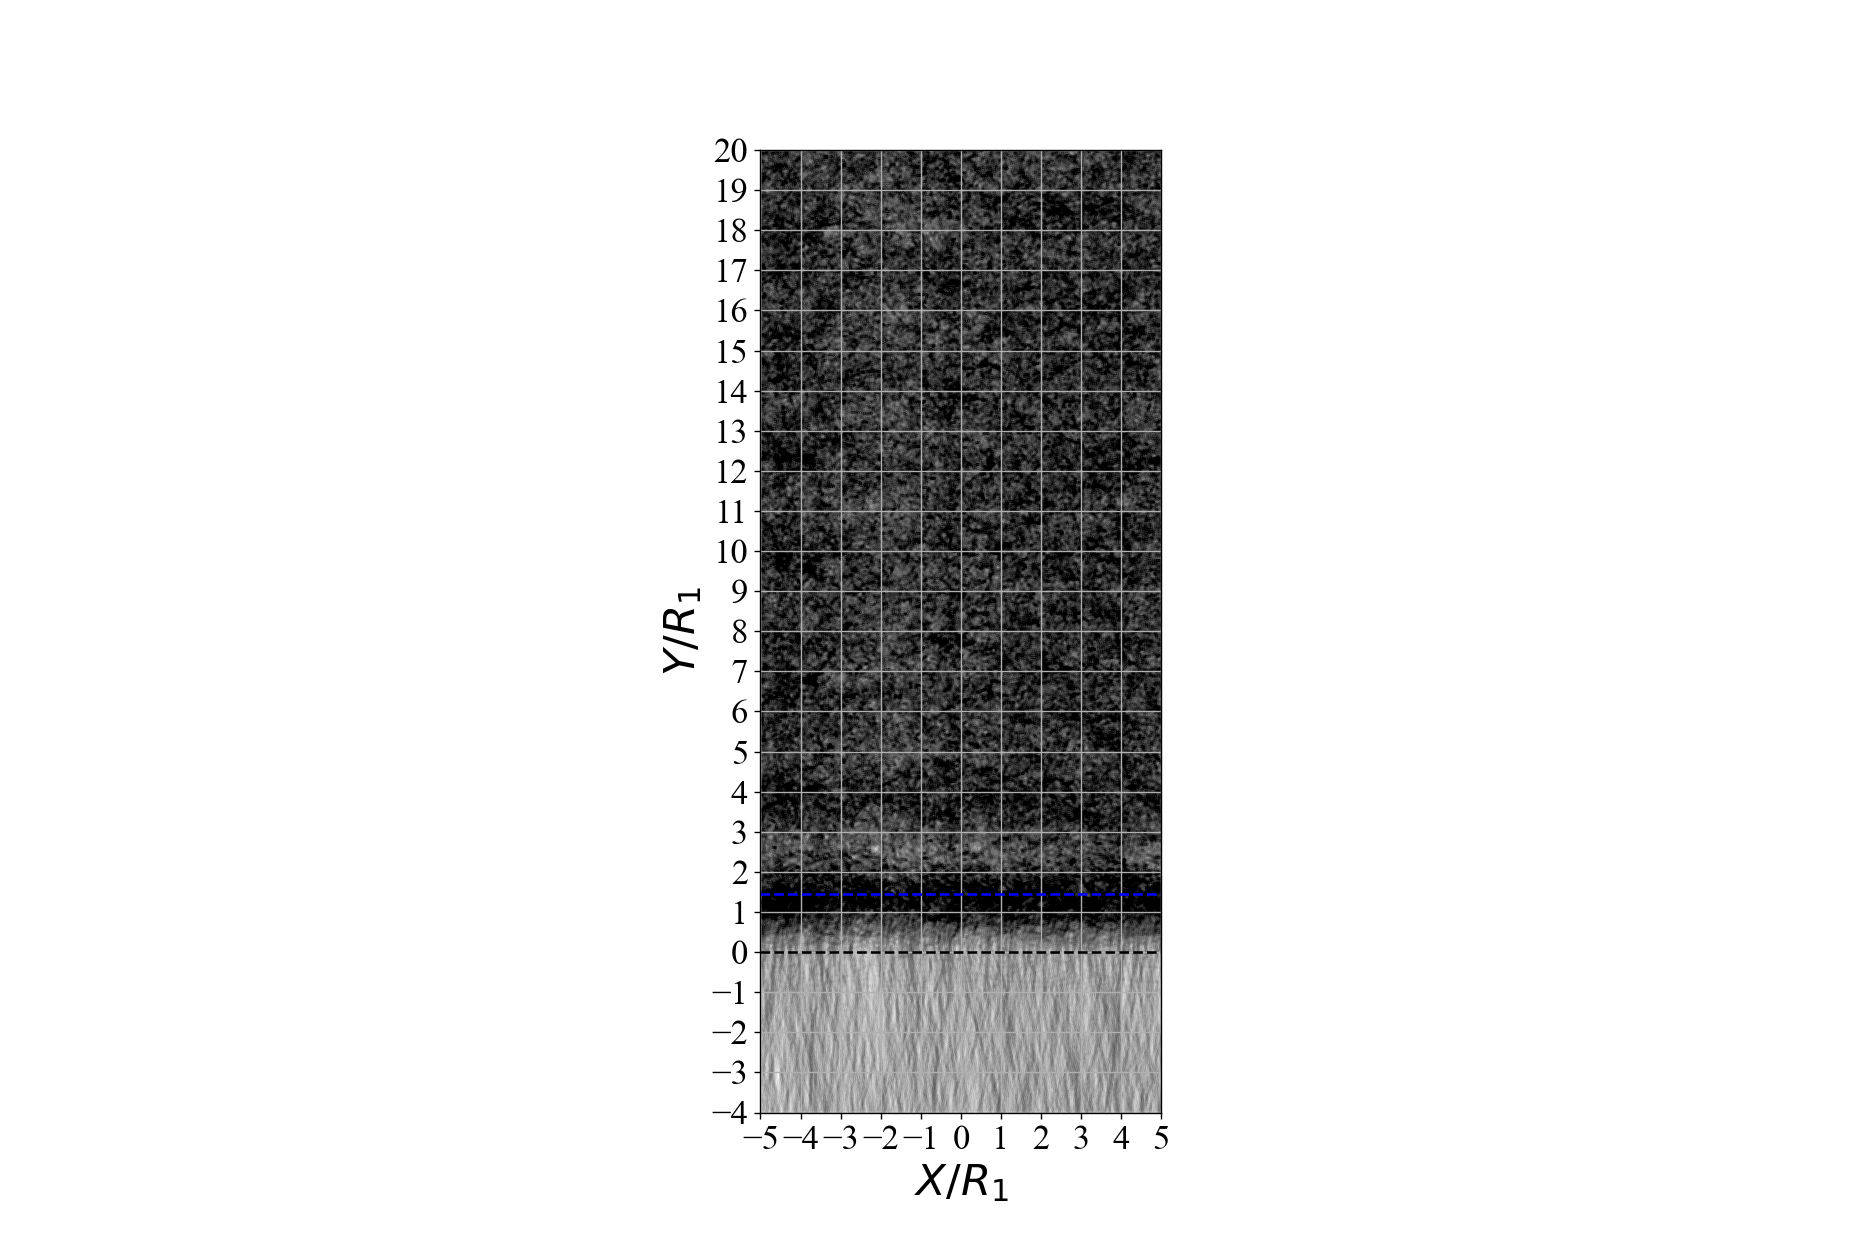

In [65]:
ynlim = 3400
y0 = -4.0*R1 

nstep = 20

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.scatter(rx[:ynlim,0:50000:nstep]/R1,ry[:ynlim,0:50000:nstep]/R1,s=0.00002, color='k') # Salvamento v1


for i in range(0,1):
    
    ax.axhline(y= (2*i+1)/2*y_p, color='blue', linestyle='--')
    
ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([-4,20]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,20.1,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size= 25)
ax.tick_params(axis='both', which='major', labelsize = 20 )
ax.grid(axis='both')

ax.set_aspect(1)

#plt.savefig('MonteCarlo01122015_3D_v1.png',dpi = 150, bbox_inches='tight',facecolor='w', edgecolor='w')

##plt.savefig('MonteCarlo01122015_3D.png', bbox_inches='tight',facecolor='w', edgecolor='w')
##plt.savefig('MonteCarlo01122015_3D_v2.png', bbox_inches='tight',facecolor='w', edgecolor='w')


#plt.savefig('MonteCarlo01122015_3D_v4.png', bbox_inches='tight',dpi=150, facecolor='w', edgecolor='w')

### Discretização

In [25]:
rx.shape, ry.shape

((4201, 50000), (4201, 50000))

In [26]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

((3400, 50000), (3400, 50000))

In [ ]:
x_1 = -5.0; y_1 = -4  ; z0lower = -1.0
x_2 =  5.0; y_2 = 20; z0upper =  1.0

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10
dz = (z0upper-z0lower)

# Definição das regiões pré-choque e pós-choque
i_up = round((0-y_1)/dy)     # Construção dos indices para os vetores
i_dw = round((y_2-y_1)/dy)

# Discretização 
x_i = round((x_2-x_1)/dx)
y_i = round((y_2-y_1)/dy)

rx = rx_d/R1; ry = ry_d/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))
c_vz = np.zeros((x_i, y_i))

x_size = np.arange(len(rx))
y_size = np.arange(len(rx[0,:]))

x_ii = np.arange(x_1, x_2  , dx)
y_jj = np.arange(y_1, y_2  , dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        c_vz[round((k-x_1)/dz), round((l-y_1)/dz)]  += vz[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc ; cm_vz = c_vz/cc # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2+cm_vz**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1*dz*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vy.T 

#Fluxo em Z   
F_Z = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vz.T 

### Salvamento (primeira iteração)

In [ ]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

#np.savetxt(path_in+'3D\\'+'cc_01_205.txt', cc) 
#np.savetxt(path_in+'3D\\'+'w_i_01_205.txt', w_i) 
#np.savetxt(path_in+'3D\\'+'cvx_01_205.txt', cm_vx)
#np.savetxt(path_in+'3D\\'+'cvy_01_205.txt', cm_vy)
#np.savetxt(path_in+'3D\\'+'cvz_01_205.txt', cm_vz)

### Carregamento 

In [27]:
cc    = np.loadtxt(path_in+'3D\\'+'cc_01_205.txt')
w_i   = np.loadtxt(path_in+'3D\\'+'w_i_01_205.txt') 
cm_vx = np.loadtxt(path_in+'3D\\'+'cvx_01_205.txt')
cm_vy = np.loadtxt(path_in+'3D\\'+'cvy_01_205.txt')
cm_vz = np.loadtxt(path_in+'3D\\'+'cvz_01_205.txt')

x_1 = -5.0; y_1 = -4  ; z0lower = -1.0
x_2 =  5.0; y_2 = 20.; z0upper =  1.0

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10
dz = (z0upper-z0lower)

# Definição das regiões pré-choque e pós-choque
i_up = round((0-y_1)/dy)     # Construção dos indices para os vetores
i_dw = round((y_2-y_1)/dy)

cc_n = cc/np.max(cc) 
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2+cm_vz**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1*dz*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vy.T 

#Fluxo em Z   
F_Z = (w_i.T*cc.T/(dx*R1*dy*R1*dz*R1))*cm_vz.T 

### Gráficos 

### Contas  

In [28]:
#Média dos fluxos (x,y,z) nas regiões pré e pós choque.
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:i_dw])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:i_dw])/1e11 

f31 = np.mean(F_Z[:][0:i_up])/1e11
f32 = np.mean(F_Z[:][i_up:i_dw])/1e11 

F_1 = np.sqrt(f11**2+f21**2+f31**2)  
F_2 = np.sqrt(f12**2+f22**2+f32**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

#Estimativa da velocidade média a partir do fluxo médio e da densidade.
v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

# Vetores dos fluxos simulados (média nos bins)
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fz = pd.DataFrame(F_Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11
Fz = Fz.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,-0.666909,-0.184380,-0.099148,-0.207041,-0.175293,-0.196713,-0.100630,-0.301102,-0.321791,-0.328631,...,-1.542265,-0.955938,2.725518,1.754737,3.018539,0.051235,1.430573,4.822051,2.000123,4.616588
-4.85,-0.228078,-0.363203,-0.323500,-0.358765,-0.103242,-0.322454,-0.315862,-0.295027,-0.172339,-0.230370,...,1.263946,-1.353748,2.304049,-0.268335,2.090229,3.519657,2.494428,1.731871,2.462339,5.149749
-4.75,0.030837,-0.181632,-0.742473,-0.597015,-0.409924,-0.589135,-0.249695,-0.124866,-0.176498,-0.332427,...,1.725216,-1.954568,-0.134259,1.133478,2.172627,4.475103,3.489605,0.638673,2.236174,3.972506
-4.65,-0.787458,-0.463637,-0.097183,-0.033642,-0.148840,-0.150967,-0.481138,-0.387197,-0.324418,-0.290066,...,2.107580,0.909734,-0.904055,-0.399342,5.442736,3.644268,1.770249,3.708705,0.801032,1.764322
-4.55,0.072547,-0.052600,-0.289049,-0.717799,-0.257905,-0.431235,-0.330405,-0.511794,-0.708431,-0.516402,...,-0.067673,-0.038010,1.466134,2.514634,2.172967,2.356475,2.482028,1.694043,2.231355,3.792810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.475615,-0.519562,-0.240558,-0.060671,-0.034630,-0.193524,-0.224633,-0.253429,-0.348683,-0.518802,...,0.773796,0.422158,3.619348,1.753577,1.752085,3.335661,2.491103,3.307600,3.191363,3.780100
4.65,-0.000872,-0.151008,-0.627956,-0.580247,-0.165074,0.155260,-0.119278,-0.205544,0.052432,0.094925,...,1.465714,-0.062923,2.621363,1.487532,0.532048,2.537118,2.301161,5.328380,3.348015,4.321329
4.75,-0.142767,-0.144806,0.342728,0.226431,-0.559153,-0.781772,-0.388862,-0.051433,-0.324624,-0.192853,...,0.174854,0.337471,0.432397,1.762642,-0.096998,2.194757,4.088367,4.716266,3.786872,4.653682
4.85,-0.122988,0.079749,-0.010176,-0.390522,-0.296841,-0.268530,-0.692988,-0.823029,-0.638988,-0.459132,...,1.000878,0.459036,1.620212,1.816071,1.193471,1.401372,2.643457,4.143485,3.668000,4.226984


In [29]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,33.794190,34.263928,26.795613,22.293148,23.394644,21.421207,27.424485,19.149052,23.137867,24.958005,...,34.669011,34.690130,34.596105,34.658907,34.571771,34.703260,34.673799,34.366651,34.645612,34.394855
-4.85,34.392181,30.214586,27.923643,33.188250,15.046074,31.901514,24.820487,30.781895,18.920106,34.283283,...,34.680273,34.676884,34.626728,34.702261,34.640292,34.524353,34.613534,34.660057,34.615832,34.319076
-4.75,29.058259,26.044965,32.169331,21.904648,15.681034,27.418310,17.946054,22.339879,15.782175,24.292758,...,34.660389,34.648212,34.703038,34.684782,34.635222,34.413549,34.527403,34.697421,34.631177,34.475181
-4.65,27.169758,19.410494,15.948492,14.105524,13.263819,10.110528,18.029764,12.328470,12.129026,12.228656,...,34.639241,34.691372,34.691520,34.701000,34.273832,34.511421,34.658118,34.504556,34.694052,34.658420
-4.55,26.630947,16.415180,20.649786,34.296504,22.161130,31.366928,21.207888,25.897633,32.981943,19.279521,...,34.703232,34.703277,34.672314,34.612072,34.635201,34.623199,34.614425,34.661926,34.631488,34.495413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,34.700039,34.699409,34.702464,34.703245,34.703281,34.702759,34.702571,34.702373,34.701546,34.699420,...,34.694670,34.700730,34.514044,34.658965,34.659041,34.542615,34.613773,34.545313,34.556246,34.496808
4.65,34.703298,34.702970,34.697616,34.698447,34.702906,34.702951,34.703093,34.702689,34.703259,34.703168,...,34.672332,34.703241,34.604152,34.671403,34.699219,34.610431,34.626920,34.291796,34.541420,34.433196
4.75,34.703005,34.702996,34.701606,34.702559,34.698793,34.694491,34.701119,34.703260,34.701780,34.702762,...,34.702858,34.701657,34.700604,34.658505,34.703163,34.633827,34.461633,34.381328,34.496065,34.389855
4.85,34.703080,34.703207,34.703297,34.701101,34.702029,34.702259,34.696378,34.693537,34.697415,34.700261,...,34.688862,34.700262,34.665456,34.655747,34.682770,34.674992,34.602472,34.455050,34.508907,34.444905


In [30]:
Fz   # Não entendi porque zerou alguns termos da matriz no fluxo em Z

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,-7.863004,-5.501647,-22.052306,-26.594954,-25.631598,-27.302236,-21.265145,-28.940319,-25.862221,-24.110348,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.85,-4.630850,-17.066510,-20.603020,-10.135593,-31.271775,-13.656804,-24.252063,-16.022072,-29.091559,-5.377947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.75,18.971967,22.933506,-12.996221,26.910014,30.955711,21.265185,29.701779,26.556225,30.906483,24.780442,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.65,21.575520,28.763461,30.821341,31.707286,32.068175,33.197490,29.648187,32.437290,32.513080,32.476064,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-4.55,-22.250984,-30.575448,-27.889455,5.249143,-26.704619,-14.840781,-27.466984,-23.094795,10.770723,-28.850516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.65,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.75,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.85,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<IPython.core.display.Javascript object>


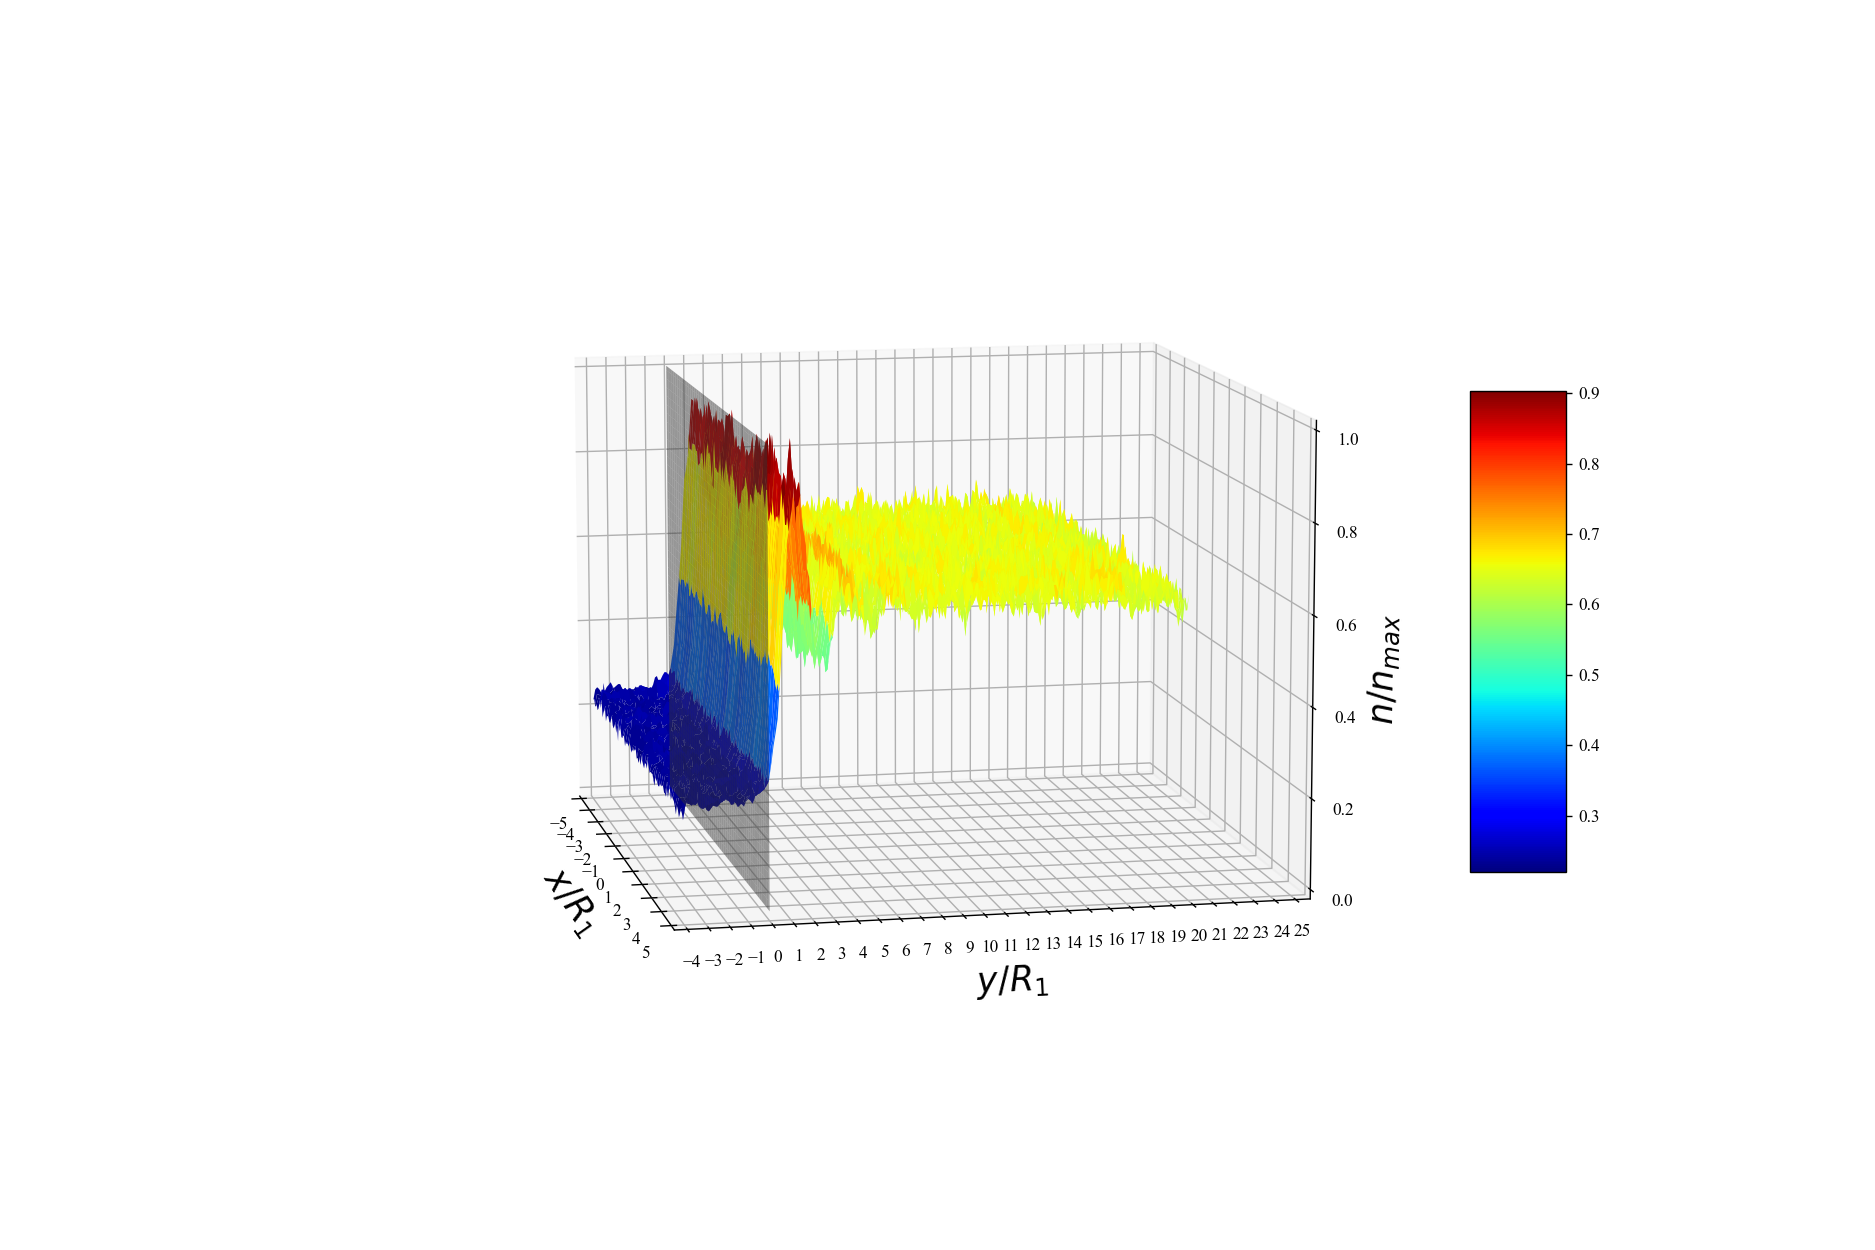

In [32]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,20.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-3.9,25.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4,25.1,1))


# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5, ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] )

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',
#dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

## Estimativa dos erros

In [33]:
#Usando transposta
Z = w_i.T*cc.T/(dx*R1*dy*R1*dz*R1)

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [34]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,8.106422,8.123485,6.337514,5.238942,5.435357,4.922500,6.288107,4.439795,5.418686,5.888192,...,22.235352,24.017513,21.635800,20.423637,20.165379,20.534555,21.913270,21.068265,21.055357,22.396555
-4.85,8.120905,7.067480,6.513299,7.743981,3.502967,7.466713,5.844345,7.244465,4.456849,8.000779,...,21.858248,22.344794,22.429661,22.573013,21.387988,21.278796,22.588974,21.933838,21.212538,20.171561
-4.75,6.831571,6.180696,7.645984,5.189810,3.732013,6.513761,4.252544,5.260527,3.725748,5.725337,...,22.546746,22.702978,22.369310,20.860367,21.890508,22.922695,22.411652,23.779753,24.187377,22.872415
-4.65,6.591652,4.673503,3.855789,3.406491,3.166368,2.415910,4.324515,2.967256,2.897199,2.908008,...,20.332302,22.083571,23.757419,23.631816,22.420386,22.437470,22.227086,22.201281,22.446176,22.403975
-4.55,6.383246,3.877035,4.869667,8.105890,5.245646,7.452491,5.028850,6.086588,7.737136,4.512048,...,23.023380,21.198197,22.330027,23.022371,22.346016,21.729848,22.844665,21.299945,23.138171,23.663088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.180694,8.140720,8.179429,8.219258,8.141952,8.214062,8.245546,8.168690,8.149825,8.180892,...,23.314246,24.705063,23.924353,24.573047,23.923178,21.986926,22.031943,22.181899,22.227499,24.057202
4.65,8.272121,8.220771,8.221320,8.173529,8.241678,8.282285,8.233861,8.259900,8.255317,8.210828,...,24.975960,25.111657,23.087388,22.499697,22.990436,22.565622,22.139711,22.324507,20.847276,22.670879
4.75,8.300911,8.252398,8.194862,8.223486,8.131847,8.124286,8.139929,8.189955,8.139459,8.176873,...,23.301201,23.438937,24.379128,22.432279,23.102079,24.076313,21.918515,22.540032,23.345114,22.367870
4.85,8.186183,8.180804,8.231304,8.226485,8.256642,8.225634,8.192150,8.211537,8.268481,8.258904,...,23.508464,23.366923,23.125361,22.505029,22.371955,23.594574,21.822188,21.588257,22.011542,21.214937


### Região pré-choque

In [35]:
n_mass[n_mass.columns[0:40]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,8.106422,8.123485,6.337514,5.238942,5.435357,4.922500,6.288107,4.439795,5.418686,5.888192,...,8.178886,8.304733,8.432963,8.486068,8.398763,8.489540,8.900027,8.695385,8.703963,8.936878
-4.85,8.120905,7.067480,6.513299,7.743981,3.502967,7.466713,5.844345,7.244465,4.456849,8.000779,...,8.199170,8.218902,8.231808,8.447102,8.264939,8.275564,8.589587,8.725987,8.742554,8.744703
-4.75,6.831571,6.180696,7.645984,5.189810,3.732013,6.513761,4.252544,5.260527,3.725748,5.725337,...,8.180277,8.177980,8.213106,8.427245,8.478512,8.317068,8.553195,8.825018,8.974051,8.866982
-4.65,6.591652,4.673503,3.855789,3.406491,3.166368,2.415910,4.324515,2.967256,2.897199,2.908008,...,8.186116,8.294164,8.356245,8.402694,8.569333,8.498491,8.687240,8.779714,9.012053,8.947601
-4.55,6.383246,3.877035,4.869667,8.105890,5.245646,7.452491,5.028850,6.086588,7.737136,4.512048,...,8.259417,8.263807,8.228726,8.333612,8.517633,8.372807,8.622029,8.749365,8.744123,8.954217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,8.180694,8.140720,8.179429,8.219258,8.141952,8.214062,8.245546,8.168690,8.149825,8.180892,...,8.231026,8.150157,8.305340,8.395218,8.613443,8.830880,8.940395,9.027179,9.124990,9.206850
4.65,8.272121,8.220771,8.221320,8.173529,8.241678,8.282285,8.233861,8.259900,8.255317,8.210828,...,8.296573,8.162467,8.396276,8.396430,8.406840,8.556961,8.558953,8.818700,8.813770,8.983070
4.75,8.300911,8.252398,8.194862,8.223486,8.131847,8.124286,8.139929,8.189955,8.139459,8.176873,...,8.388099,8.258147,8.319231,8.342045,8.499852,8.592467,8.482756,8.862018,8.822588,8.792859
4.85,8.186183,8.180804,8.231304,8.226485,8.256642,8.225634,8.192150,8.211537,8.268481,8.258904,...,8.333132,8.266085,8.324277,8.370189,8.560633,8.659104,8.690978,8.743350,9.026691,9.086138


### Região pós-choque 

In [36]:
n_mass[n_mass.columns[40:]]

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,9.397813,10.071552,11.300658,12.643459,13.985034,15.169462,18.226893,20.156445,23.795987,26.673300,...,22.235352,24.017513,21.635800,20.423637,20.165379,20.534555,21.913270,21.068265,21.055357,22.396555
-4.85,9.210149,9.870943,10.893171,12.441250,14.472995,15.793918,17.419959,19.222722,22.821880,24.474923,...,21.858248,22.344794,22.429661,22.573013,21.387988,21.278796,22.588974,21.933838,21.212538,20.171561
-4.75,9.527512,10.693300,11.398660,12.836723,14.213237,17.322587,18.510309,20.717705,23.548473,27.833109,...,22.546746,22.702978,22.369310,20.860367,21.890508,22.922695,22.411652,23.779753,24.187377,22.872415
-4.65,9.119475,10.275994,11.124749,12.908655,14.345689,16.452755,18.775666,22.029110,23.980414,24.914858,...,20.332302,22.083571,23.757419,23.631816,22.420386,22.437470,22.227086,22.201281,22.446176,22.403975
-4.55,9.377657,9.814993,10.756917,12.177882,14.318428,16.398806,19.482014,21.535243,25.247588,28.538634,...,23.023380,21.198197,22.330027,23.022371,22.346016,21.729848,22.844665,21.299945,23.138171,23.663088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,9.646234,10.401899,11.498109,12.856049,14.497282,16.440399,19.664568,22.206589,25.299442,26.186359,...,23.314246,24.705063,23.924353,24.573047,23.923178,21.986926,22.031943,22.181899,22.227499,24.057202
4.65,9.678349,10.034394,11.838543,12.988197,14.565154,16.428401,18.624804,21.015290,22.997308,27.060189,...,24.975960,25.111657,23.087388,22.499697,22.990436,22.565622,22.139711,22.324507,20.847276,22.670879
4.75,9.432477,10.420171,11.777167,11.909289,14.523111,16.663574,17.844923,21.747649,25.112397,27.113451,...,23.301201,23.438937,24.379128,22.432279,23.102079,24.076313,21.918515,22.540032,23.345114,22.367870
4.85,9.460757,10.387894,11.814419,12.921915,13.817796,14.988663,18.462164,20.536652,25.175288,28.058008,...,23.508464,23.366923,23.125361,22.505029,22.371955,23.594574,21.822188,21.588257,22.011542,21.214937


In [37]:
#Número de partículas na região pré e pós choque.

np.sum(cc[:, :40]), np.sum(cc[:, 40:])

(10173901.0, 136403051.0)

In [38]:
cc[:,:40].shape, cc[:,40:].shape

((100, 40), (100, 200))

In [39]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:40]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[40:]]))

d_up, d_dw

(8.270530866485112, 22.23452949365523)

### Estimativa do erro percentual 

In [40]:
# Região pré-choque
DVporV1 = (2*dx*dy)/(2*40)

Dn1     = DVporV1*np.sum(cc[:,0:40])

dn1 = 1/(np.sqrt(Dn1))

# Região pós-choque

DVporV2 = (2*dx*dy)/(2*200)

Dn2     = DVporV2*np.sum(cc[:,40:])    #cc[:,40:].shape

dn2 = 1/(np.sqrt(Dn2))

In [41]:
dn1, dn2

(0.01982833474029343, 0.01210885156756037)

In [42]:
nsig_up = n_mass[n_mass.columns[0:40]]*dn1   # 0.0309 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[40:]] *dn2   # 0.0205 é o erro percentual estimado para cada bin na região pós-choque

In [43]:
cc[:,:40].shape[0]*cc[:,:40].shape[1]

4000

In [44]:
cc[:,40:].shape[0]*cc[:,40:].shape[1]

20000

In [45]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])  # Propagação do erro pré-choque 
                                                                                  # para o calculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])  # Propagação do erro pós-choque

err_up, err_dw

(0.16399085450059583, 0.2692346173132145)

In [46]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 8.271  \pm 0.164 $

In [47]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.3} $'))

$n_2: 22.235  \pm 0.269 $

### Incerteza na densidade 

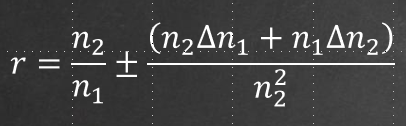

In [48]:
deln = (d_dw*err_up+d_up*err_dw)/(d_dw)**2
deln

0.011879607581674436

### Incerteza na velocidade

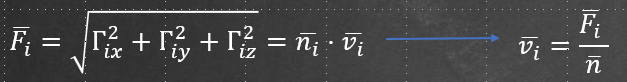

#### Cálculo dos fluxos médios

In [49]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:40]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[40:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:40]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[40:]]))

Fz_up = np.mean(np.mean(Fz[Fz.columns[0:40]]))
Fz_dw = np.mean(np.mean(Fz[Fz.columns[40:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw, Fz_up, Fz_dw

(-1.489442447441376,
 -0.02099961421067163,
 34.43718030119014,
 34.4937316345915,
 -0.07270277028994954,
 0.0)

#### Estimativa das incertezas dos fluxos médios

In [50]:
nfx_up = Fx[Fx.columns[0:40]] * dn1  # 0.0129 é o erro percentual estimado para cada bin na região pré-choque
nfx_dw = Fx[Fx.columns[40:]]  * dn2  # 0.0229 é o erro percentual estimado para cada bin na região pós-choque

nfy_up = Fy[Fy.columns[0:40]] * dn1
nfy_dw = Fy[Fy.columns[40:]]  * dn2

nfz_up = Fz[Fz.columns[0:40]] * dn1
nfz_dw = Fz[Fz.columns[40:]]  * dn2

In [51]:
nfx_up 

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,-0.013224,-0.003656,-0.001966,-0.004105,-0.003476,-0.003900,-0.001995,-0.005970,-0.006381,-0.006516,...,-0.058864,-0.057346,-0.061056,-0.065770,-0.070035,-0.072886,-0.100619,-0.099656,-0.086753,-0.110770
-4.85,-0.004522,-0.007202,-0.006414,-0.007114,-0.002047,-0.006394,-0.006263,-0.005850,-0.003417,-0.004568,...,-0.051814,-0.061079,-0.069029,-0.091093,-0.075347,-0.081566,-0.106056,-0.109391,-0.110532,-0.111276
-4.75,0.000611,-0.003601,-0.014722,-0.011838,-0.008128,-0.011682,-0.004951,-0.002476,-0.003500,-0.006591,...,-0.052054,-0.054197,-0.064558,-0.089582,-0.103341,-0.097779,-0.123121,-0.129154,-0.144380,-0.113424
-4.65,-0.015614,-0.009193,-0.001927,-0.000667,-0.002951,-0.002993,-0.009540,-0.007677,-0.006433,-0.005752,...,-0.047306,-0.059850,-0.063631,-0.071871,-0.083009,-0.075493,-0.104022,-0.118272,-0.133044,-0.115470
-4.55,0.001438,-0.001043,-0.005731,-0.014233,-0.005114,-0.008551,-0.006551,-0.010148,-0.014047,-0.010239,...,-0.043334,-0.053954,-0.051709,-0.068703,-0.082451,-0.080361,-0.091784,-0.107691,-0.102705,-0.109298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,-0.009431,-0.010302,-0.004770,-0.001203,-0.000687,-0.003837,-0.004454,-0.005025,-0.006914,-0.010287,...,-0.050873,-0.049358,-0.066745,-0.060610,-0.089133,-0.094428,-0.090360,-0.106123,-0.117488,-0.131789
4.65,-0.000017,-0.002994,-0.012451,-0.011505,-0.003273,0.003079,-0.002365,-0.004076,0.001040,0.001882,...,-0.047079,-0.036094,-0.058204,-0.059805,-0.081121,-0.079931,-0.095228,-0.108404,-0.115241,-0.104210
4.75,-0.002831,-0.002871,0.006796,0.004490,-0.011087,-0.015501,-0.007710,-0.001020,-0.006437,-0.003824,...,-0.040960,-0.038530,-0.047531,-0.061073,-0.081124,-0.088426,-0.081107,-0.106880,-0.119055,-0.103093
4.85,-0.002439,0.001581,-0.000202,-0.007743,-0.005886,-0.005324,-0.013741,-0.016319,-0.012670,-0.009104,...,-0.043625,-0.043674,-0.052590,-0.059964,-0.068107,-0.074770,-0.085938,-0.106044,-0.119874,-0.124107


In [52]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])

errfz_up = np.sum(np.sum(np.abs(nfz_up)))/(cc[:,:40].shape[0]*cc[:,:40].shape[1])
errfz_dw = np.sum(np.sum(np.abs(nfz_dw)))/(cc[:,40:].shape[0]*cc[:,40:].shape[1])

errfx_up, errfx_dw, errfy_up, errfy_dw, errfz_up, errfz_dw

(0.030109127049092452,
 0.0330327105086947,
 0.6828319385238372,
 0.41767947637453007,
 0.008373413880014575,
 0.0)

#### Região pré-choque

In [53]:
f_upx = Fx_up**2  
f_upy = Fy_up**2
f_upz = Fz_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)
delf_upz =  np.abs(2*Fz_up*errfz_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy + f_upz)
delf_up = (delf_upx + delf_upy + delf_upz)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(34.469, 0.684)

#### Região pós-choque

In [54]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2
f_dwz = Fz_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)
delf_dwz =  np.abs(2*Fz_dw*errfz_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy + f_dwz)
delf_dw = (delf_dwx + delf_dwy + delf_dwz)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(34.494, 0.418)

#### Incerteza nas velocidades

In [55]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(416774.357, 16528.361, 155135.903, 3757.125)

#### Estimativa do r a partir das velocidades

In [56]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.687, 0.172)

<IPython.core.display.Javascript object>


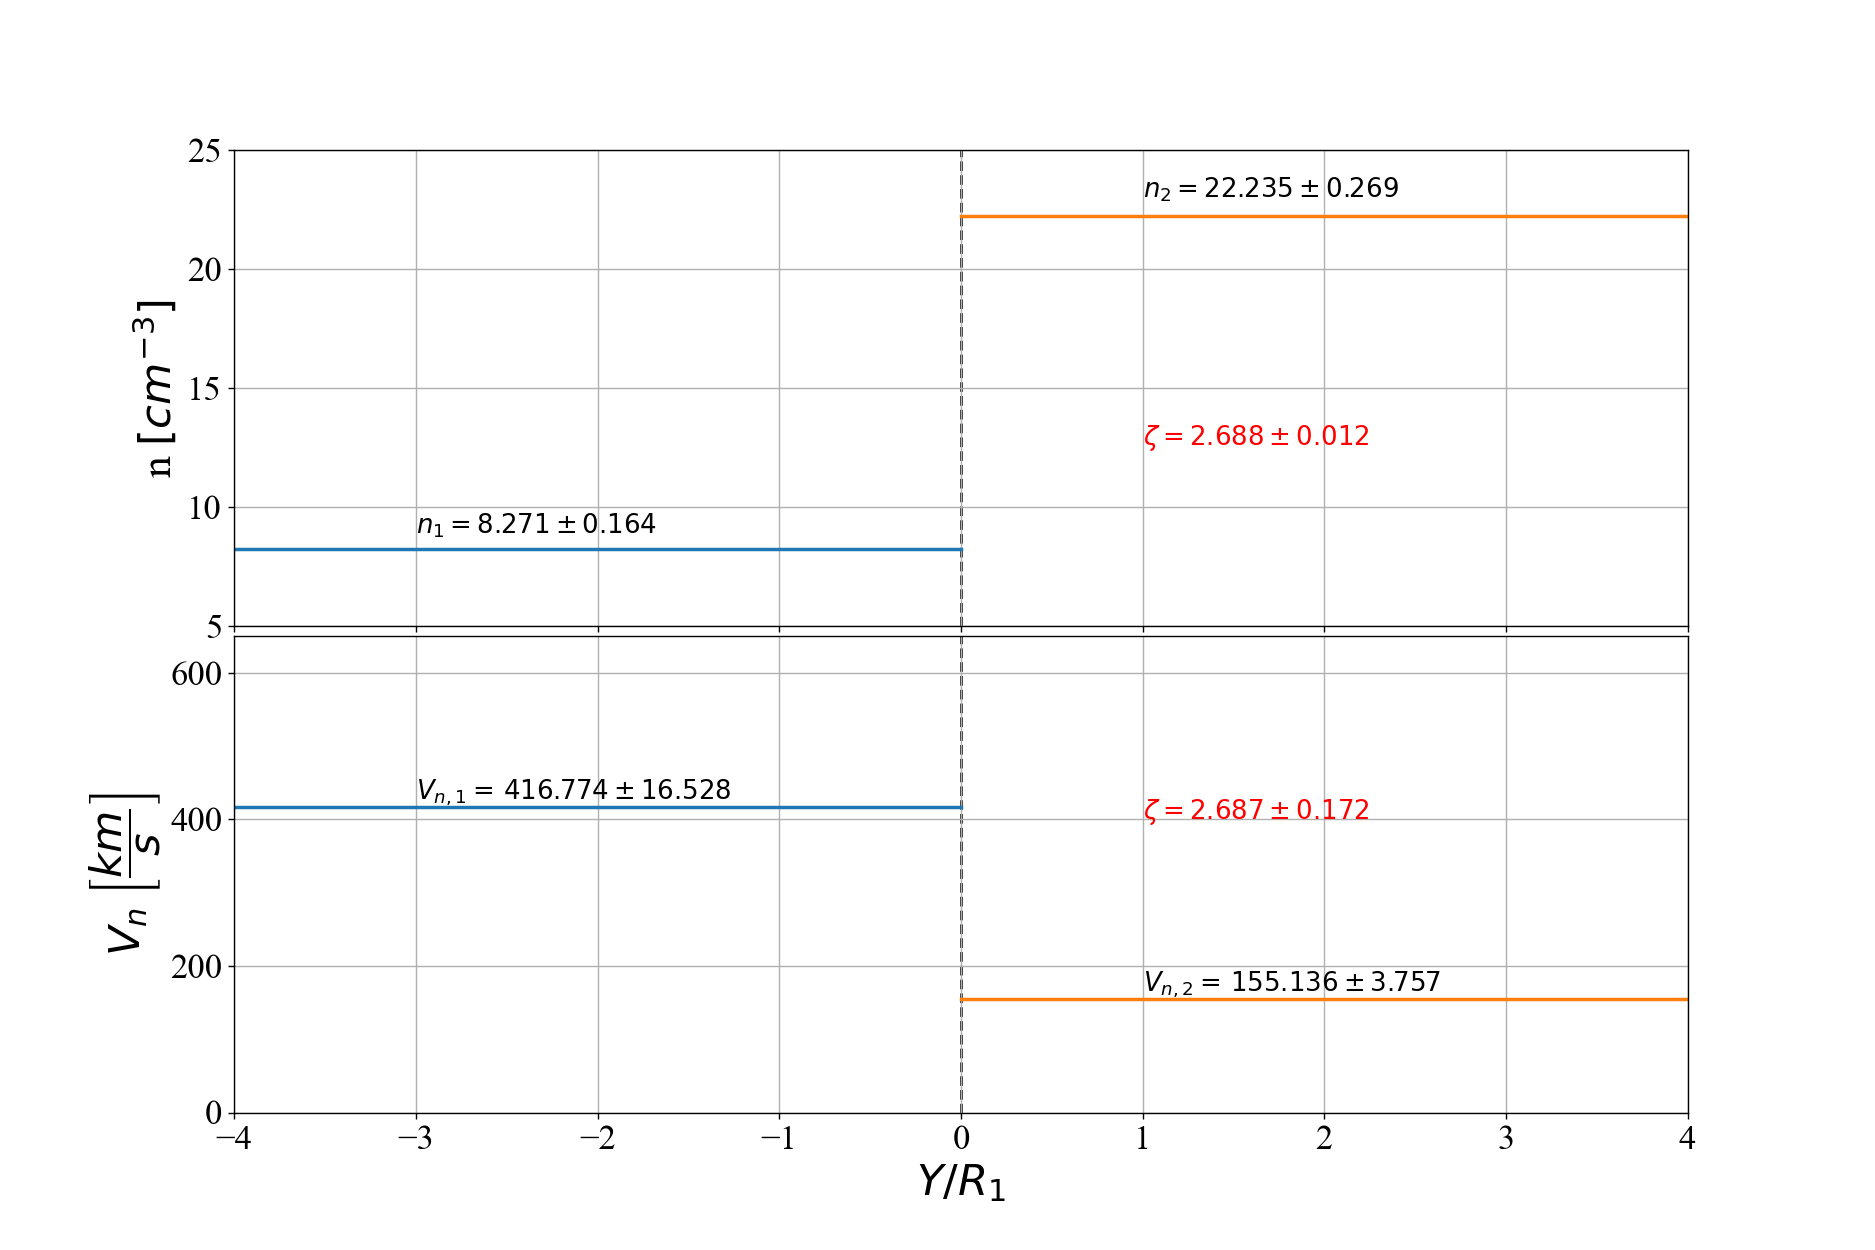

In [57]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)} \pm {round(err_up,3)}$',    xy= (-3,8.9), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}$',    xy= (1,23), size=15)  
ax[0].annotate(f'$\zeta   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,12.6), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[cm^{-3} \right]$', size=25)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)
ax[0].grid(axis='both')
ax[0].set_ylim([5,25])
ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=20)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate("$V_{n,1}$" + f'$ =  \, {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}$',xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate("$V_{n,2}$" + f'$ =  \, {round(v_dw*1e2,3)} \pm {round(Del_vdw*1e2,3)}$',xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$\zeta   = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$V_n$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=25)
ax[1].set_xlabel(r'$Y/R_1$', size=25)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=20)  
#ax[1].set_aspect(1)

#plt.savefig(path_in+'boris2D\\Parametrosfisicos_50000_particles_01.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

#plt.savefig('MonteCarloParametrosfisicos_01122015_3D.png', bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [58]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [59]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [60]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95      8.254267
-3.85      8.155399
-3.75      8.137352
-3.65      8.148351
-3.55      8.046018
            ...    
 19.55    22.066419
 19.65    22.172986
 19.75    21.875908
 19.85    21.910128
 19.95    21.926240
Name: mean, Length: 240, dtype: float64

<IPython.core.display.Javascript object>


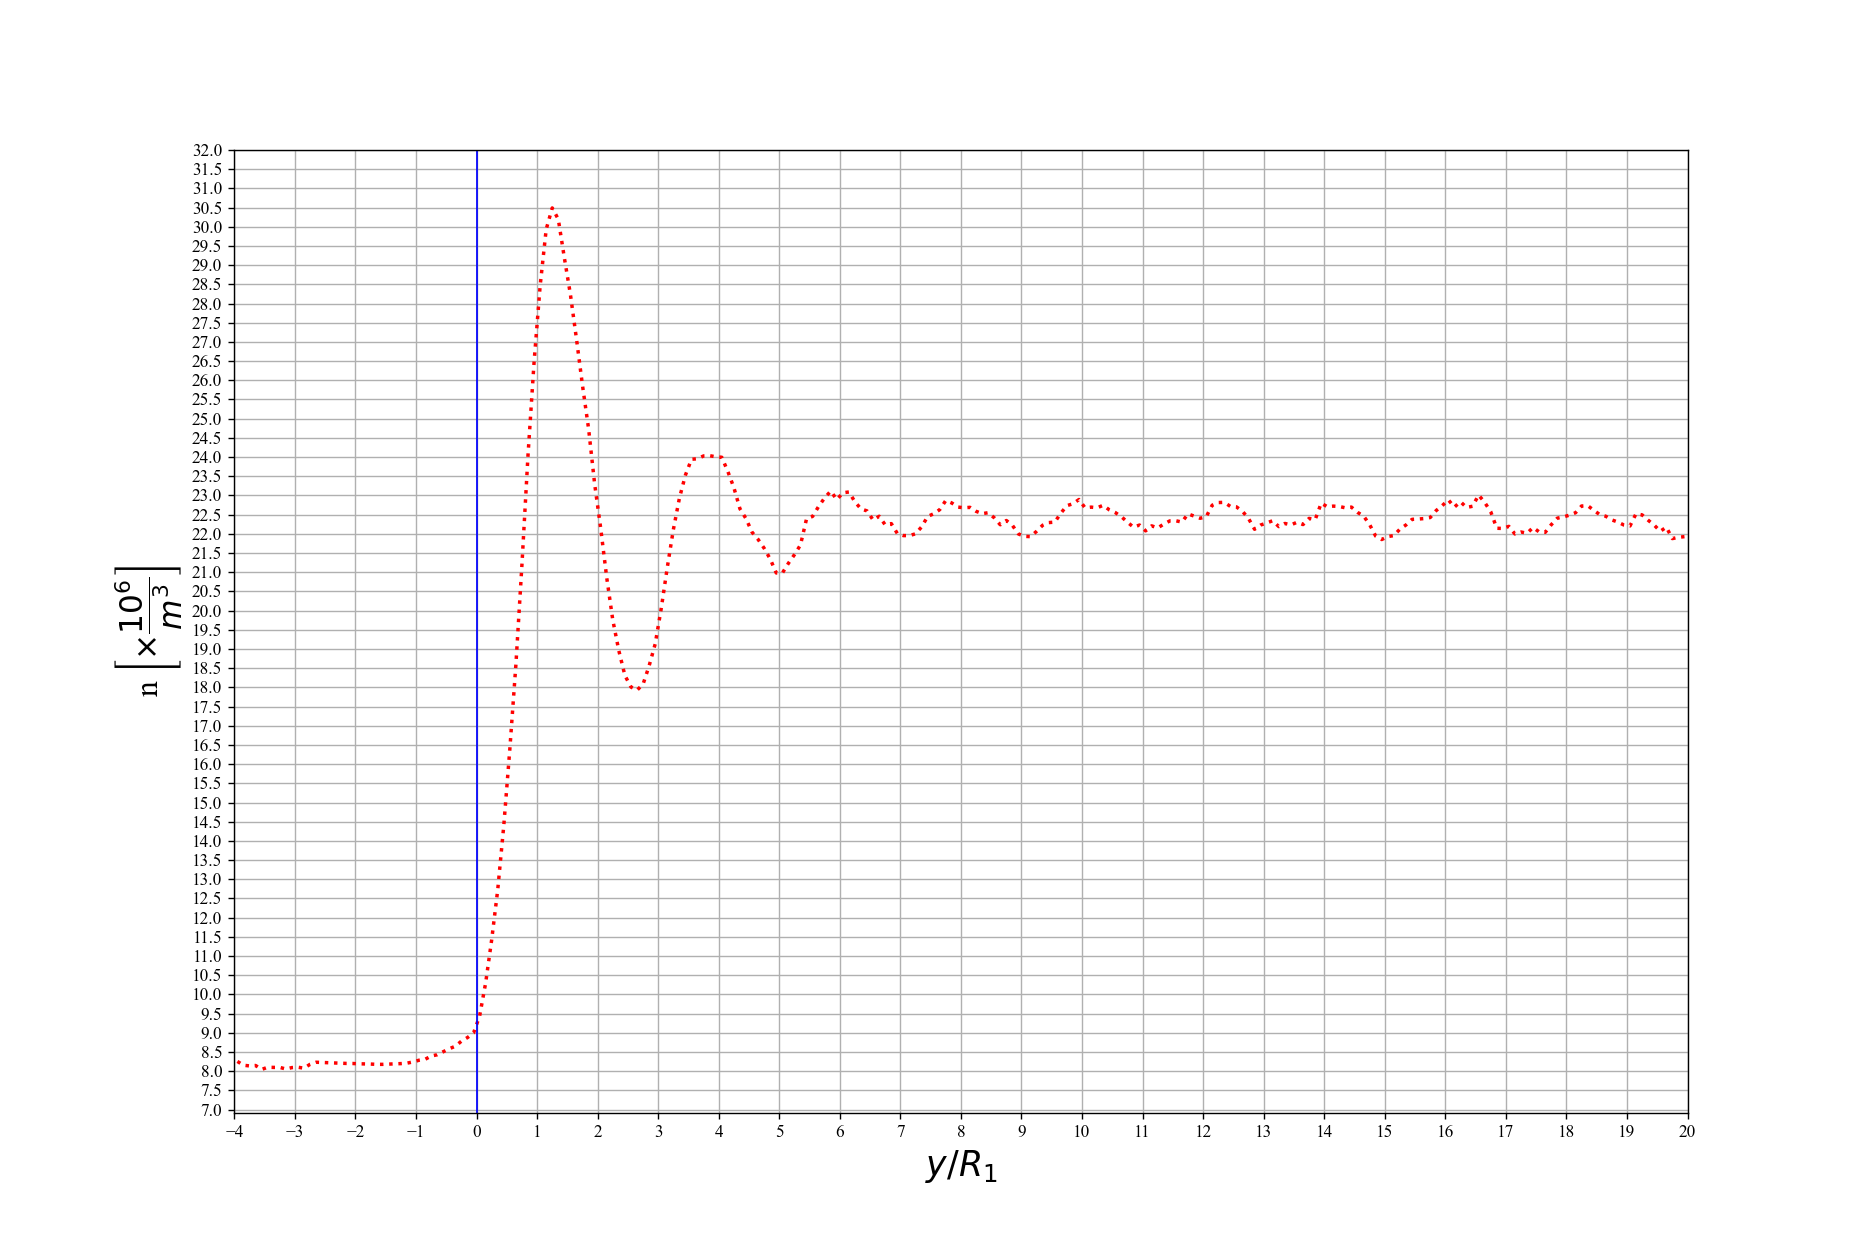

In [61]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,20])
ax.set_xticks(np.arange(-4,20.1,1))
ax.set_yticks(np.arange(7,32.1,0.5))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()

plt.show()

In [ ]:
nump = 10  

fig, ax = plt.subplots(3, figsize=(20, 15))


ax[0].scatter(ry[:,0:50000:100]/R1,rx[:,0:50000:100]/R1,s=0.0002, color='k')
ax[0].scatter(ry[:,nump]/R1,rx[:,nump]/R1, s=0.2, color='r')
ax[0].scatter(ry[:,1200]/R1,rx[:,1200]/R1, s=0.2, color='g')

ax[0].set_xlim([-4,25]);  #y0/R1
ax[0].set_ylim([-5,5])
ax[0].set_yticks(np.arange(-5,5.1,1))
ax[0].set_xticks(np.arange(-4,25.1,2))
ax[0].set_xlabel(r'$y/R_1$',size=20);ax[0].set_ylabel(r'$x/R_1$',size= 20)

ax[0].axvline(x = 0, color='k', linestyle='--',lw=2, zorder=10)
ax[0].axvline(x = 21.5, color='k', linestyle='--')

#for i in range(16):
#    ax[0].axvline(x =(2*i+1)/2*y_p, color='b', linestyle='--',lw=2, zorder=10)
#    ax[2].axvline(x =(2*i+1)/2*y_p, color='b', linestyle='--',lw=2, zorder=10)


ax[1].scatter(rx[:,0:50000:100]/R1,rz[:,0:50000:100]/R1,s=0.0002, color='k')
ax[1].scatter(rx[:,nump]/R1,rz[:,nump]/R1, s=0.2, color='r')
ax[1].scatter(rx[0,nump]/R1,rz[0,nump]/R1, s=0.8, color='b')
ax[1].scatter(rx[:,1200]/R1,rz[:,1200]/R1, s=0.2, color='g')
ax[1].set_ylim([-1,1]);  #y0/R1
ax[1].set_xlim([-5,5])
ax[1].set_xticks(np.arange(-5,5.1,1))
ax[1].set_yticks(np.arange(-1,1.1,0.5))
ax[1].set_xlabel(r'$x/R_1$',size=20);ax[1].set_ylabel(r'$z/R_1$',size= 20)

ax[2].scatter(ry[:,0:50000:100]/R1,rz[:,0:50000:100]/R1,s=0.0002, color='k')
ax[2].scatter(ry[:,nump]/R1,rz[:,nump]/R1, s=0.2, color='r')
ax[2].scatter(ry[:,1200]/R1,rz[:,1200]/R1, s=0.2, color='g')
ax[2].set_ylim([-1,1]);  #y0/R1
ax[2].set_xlim([-4,25])
ax[2].set_xticks(np.arange(-4,25.1,2))
ax[2].set_yticks(np.arange(-1,1.1,0.5))
ax[2].set_xlabel(r'$y/R_1$',size=20);ax[2].set_ylabel(r'$z/R_1$',size= 20)
ax[2].axvline(x = 21.5, color='k', linestyle='--')

for i in range(3):
    ax[i].grid()
    #ax[i].set_aspect(1)
    
plt.show()

#plt.savefig(path_in+'3D\\'+'Graficodetrajectoria3D_50000_particles.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')